In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from video import *
import numpy as np
import ultralytics
import cv2 as cv
from utils import *

In [ ]:
query = load_video("train/task1/06_query.mp4")
reference = load_video("train/task1/06_reference.mp4")

In [4]:
F = np.load("fundamental_matrices/AB.npy")

In [5]:
def get_objects_camera_A(frame):
    objects = frame.get_objects()
    result = []
    for object in objects:
        x1, y1, x2, y2 = object["bbox"]
        center = np.array([(x1 + x2) / 2, (y1 + y2) / 2, 1])
        if center[1] < 500:
            continue
        result.append(object)
    return result

In [6]:
def get_objects_camera_B(frame):
    objects = frame.get_objects()
    result = []
    for object in objects:
        x1, y1, x2, y2 = object["bbox"]
        center = np.array([(x1 + x2) / 2, (y1 + y2) / 2, 1])
        if center[1] < 700:
            continue
        result.append(object)
    return result

In [7]:
best_frame = 0
max_objects = 0

for i in range(query.num_frames()):
    objects = get_objects_camera_A(query.get_frame(i))
    if len(objects) > max_objects:
        max_objects = len(objects)
        best_frame = i
print(f"Best frame: {best_frame}, max objects: {max_objects}")

Best frame: 135, max objects: 7


[{'class': 'car', 'bbox': [1411, 654, 1657, 856]}, {'class': 'car', 'bbox': [561, 797, 1056, 994]}, {'class': 'truck', 'bbox': [1082, 531, 1363, 789]}, {'class': 'car', 'bbox': [844, 931, 1363, 996]}]


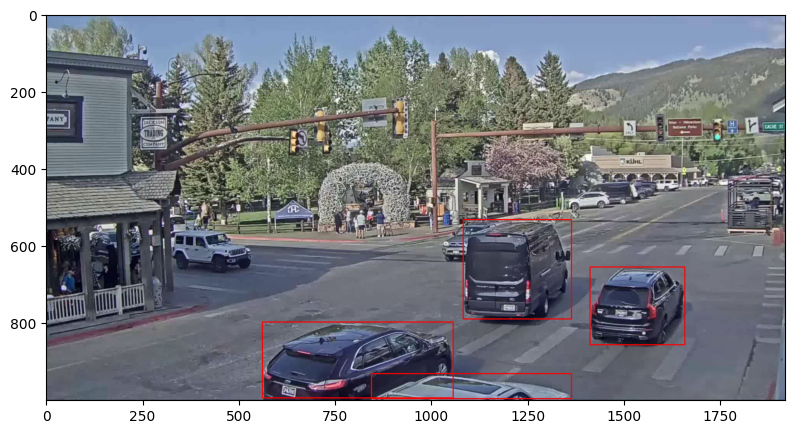

In [9]:
query_frame = query.get_frame(0)
objects_plot = query_frame.raw().copy()
objects_a = get_objects_camera_A(query_frame) 
print(objects_a)

for object in objects_a:
    x1, y1, x2, y2 = object["bbox"]
    cv.rectangle(objects_plot, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.figure(figsize=(10, 5))
plt.imshow(objects_plot)
plt.show()

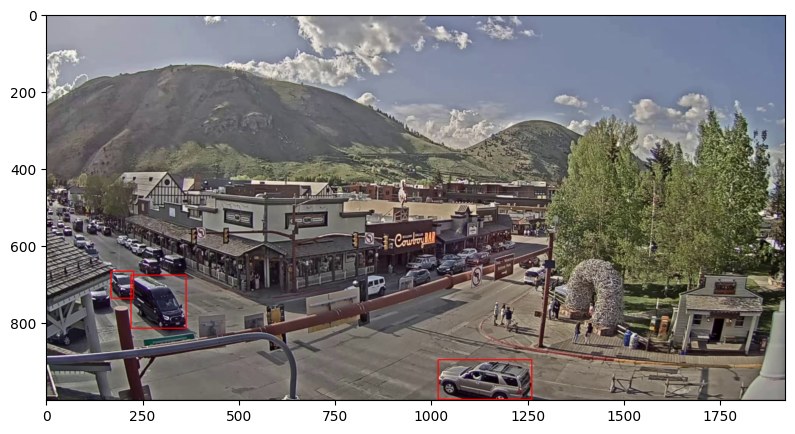

In [11]:
reference_frame = reference.get_frame(407)
objects_plot = reference_frame.raw().copy()
objects_b = get_objects_camera_B(reference_frame) 

for object in objects_b:
    x1, y1, x2, y2 = object["bbox"]
    cv.rectangle(objects_plot, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.figure(figsize=(10, 5))
plt.imshow(objects_plot)
plt.show()

6004.865170016848
[{'class': 'car', 'bbox': [1411, 654, 1657, 856]}, {'class': 'car', 'bbox': [561, 797, 1056, 994]}, {'class': 'truck', 'bbox': [1082, 531, 1363, 789]}, {'class': 'car', 'bbox': [844, 931, 1363, 996]}]


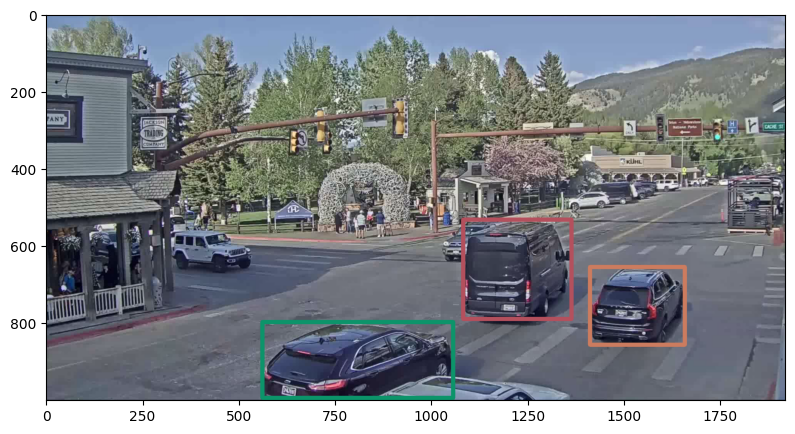

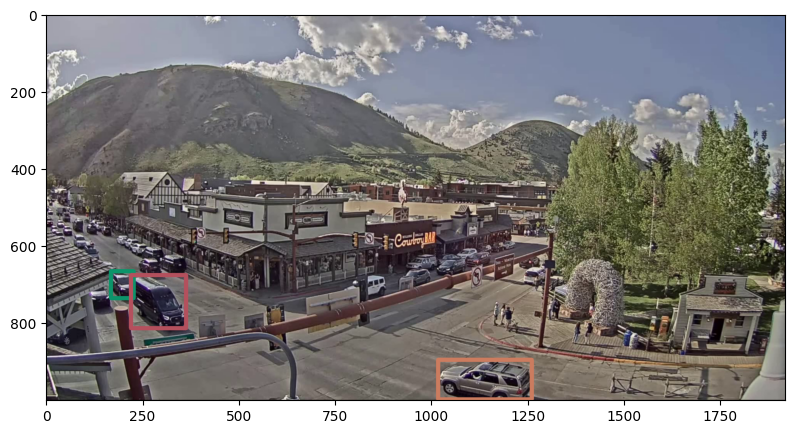

In [12]:
matching_query = query_frame.raw().copy()
matching_reference = reference_frame.raw().copy()

assignment, cost, _ = get_assignment(objects_a, objects_b, query_frame.raw().copy(), reference_frame.raw().copy(), F)
print(cost)

print(objects_a)
for i in range(len(assignment[0])):
    a = assignment[0][i]
    b = assignment[1][i]

    box_a = objects_a[a]["bbox"]
    box_b = objects_b[b]["bbox"]

    color = np.random.randint(0, 255, size=3).tolist()
    cv.rectangle(matching_query, (box_a[0], box_a[1]), (box_a[2], box_a[3]), color, 10)
    cv.rectangle(matching_reference, (box_b[0], box_b[1]), (box_b[2], box_b[3]), color, 10)

plt.figure(figsize=(10, 5))
plt.imshow(matching_query)
plt.show()
plt.figure(figsize=(10, 5))
plt.imshow(matching_reference)
plt.show()

In [13]:
num_query_frames = query.num_frames()
num_reference_frames = reference.num_frames()
print(num_query_frames)
costs = []

for i in range(0, num_reference_frames-num_query_frames+1):
    total_cost = 0

    for t in range(num_query_frames):
        frame_a = query.get_frame(t)
        frame_b = reference.get_frame(i + t)

        objects_a = get_objects_camera_A(frame_a) 
        objects_b = get_objects_camera_B(frame_b) 

        assingment, cost, _ = get_assignment(objects_a, objects_b, frame_a.raw(), frame_b.raw(), F) 
        total_cost += cost

    costs.append(total_cost)
    print(f"Frame {i}: cost = {total_cost:.2f}")

180
Frame 0: cost = 2640871.83
Frame 1: cost = 2637897.69
Frame 2: cost = 2631902.53
Frame 3: cost = 2625893.10
Frame 4: cost = 2619949.49
Frame 5: cost = 2616980.99
Frame 6: cost = 2619956.65
Frame 7: cost = 2614019.69
Frame 8: cost = 2620030.83
Frame 9: cost = 2629024.62
Frame 10: cost = 2623133.08
Frame 11: cost = 2605358.39
Frame 12: cost = 2590550.07
Frame 13: cost = 2575766.28
Frame 14: cost = 2549125.39
Frame 15: cost = 2534285.92
Frame 16: cost = 2522323.05
Frame 17: cost = 2522280.73
Frame 18: cost = 2525169.15
Frame 19: cost = 2516230.01
Frame 20: cost = 2510278.80
Frame 21: cost = 2507373.29
Frame 22: cost = 2495571.21
Frame 23: cost = 2483718.49
Frame 24: cost = 2474874.71
Frame 25: cost = 2465916.11
Frame 26: cost = 2471851.90
Frame 27: cost = 2468844.32
Frame 28: cost = 2462857.00
Frame 29: cost = 2462836.90
Frame 30: cost = 2456830.94
Frame 31: cost = 2450814.59
Frame 32: cost = 2444817.83
Frame 33: cost = 2441767.29
Frame 34: cost = 2441711.68
Frame 35: cost = 2444657.0

407


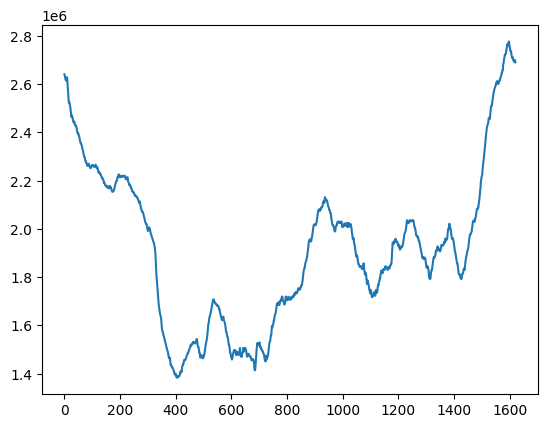

In [14]:
plt.plot(costs)
print(np.argmin(costs))